In [1]:
import pandas as pd
import json
import cv2
import os
import math
import datetime
import numpy as np
from PIL import Image
from IPython.display import clear_output
import json 
import random
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

##### Change "who_is_running_this_code" before running.

In [2]:
# Variables.
# ------------------------------------------

who_is_running_this_code = "hogni"
library = "Library"
video_folder = "16032021"

file_name = "hogni_30fps_highup_16032010"
parent_parth = f"/Users/{who_is_running_this_code}/{library}/Mobile Documents/com~apple~CloudDocs/Bachelor Project/Videos/{video_folder}/"

counter_path = f"{parent_parth}Data/{file_name}/counterData_{file_name}.csv"
tracker_path = f"{parent_parth}Data/{file_name}/tracker_{file_name}.json"
video_path = f"{parent_parth}Processed/{file_name}.mp4"
photo_path = f"{parent_parth}Photos/{file_name}"
save_labels_path = f"{parent_parth}Data/{file_name}/"
db_path = f"{parent_parth}Data/{file_name}/db_{file_name}.csv"
distance = 1
orientation = 180
notherly_correction_factor = 180
classes = 16

In [3]:
# Velocity Calculations
# ------------------------------------------

def calculate_velocity(distance, df):
    """Velocity Calculations: v = S/t """
    velocit_dictionary = {}
    for index, row in df.iterrows():
        if row[4] in velocit_dictionary.keys():
            velocit_dictionary[row[4]].append(row[1])
        else:
            velocit_dictionary[row[4]] = [row[1]]

    for key, value in velocit_dictionary.copy().items():
        if value[0] > value[1]:
            difference = (value[0]-value[1])
        else:
            difference = (value[1]-value[0])
        velocit_dictionary[key] = difference

    for key, value in velocit_dictionary.copy().items():
        t = velocit_dictionary[key].total_seconds()
        if t == 0:
            t = 1
            velocit_dictionary[key] = distance/t
        else:
            velocit_dictionary[key] = distance/t
    return velocit_dictionary

# Absolute Heading 
# ------------------------------------------

def calculate_true_heading(frame_orientation, df):
    true_heading_dictionary = {}
    for index, row in df.iterrows():
        true_heading = row["bearing_og"] + frame_orientation
        if true_heading > 360:
            true_heading = true_heading - 360
        if true_heading < 0:
            true_heading = true_heading + 360
        true_heading_dictionary[row[0]] = true_heading
    return true_heading_dictionary

# Init DataFrames
# ------------------------------------------

# Counter
def create_counter_df(path, distance, orientation, notherly_correction_factor):
    """Read and format counter df"""
    columns = ["frameId", "timestamp", "counter_area", "ObjectClass", 
            "UniqueID", "bearing_og", "countingDirection", "angle"]

    counter = pd.read_csv(path, names=columns)
    counter = counter[counter.duplicated(subset=["UniqueID"], keep=False)].sort_values("UniqueID")
    counter['timestamp'] = pd.to_datetime(counter['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')
    counter = fix_df(counter)
    counter = add_velocity_to_df(distance, counter)
    counter = add_true_heading_to_df(orientation, counter, notherly_correction_factor)
    return counter

def add_velocity_to_df(distance, counter_df):
    """ Calculates speeds (and append to df) speeds: {UniqueID: velocity} """
    speeds = calculate_velocity(distance, counter_df)
    for key, value in speeds.items():
        counter_df.loc[counter_df["UniqueID"]==key, "velocity"]=value
    return counter_df

def add_true_heading_to_df(orientation, counter_df, notherly_correction_factor):
    """ Calculates true heading (and append to df): {frameId: true_heading} """
    true_heading = calculate_true_heading(orientation, counter_df)
    for key, value in true_heading.items():
        counter_df.loc[counter_df["frameId"]==key, "true_heading"]=value
        corrected_heading = value + notherly_correction_factor
        if corrected_heading > 360:
            counter_df.loc[counter_df["frameId"]==key, "adjusted_true_heading"]= corrected_heading - 360
        else:
            counter_df.loc[counter_df["frameId"]==key, "adjusted_true_heading"]= corrected_heading
    return counter_df

# Tracker
def create_tracker_df(tracker_path):
    with open(tracker_path) as f:
        tracker = json.load(f)
    tracker_flattend = pd.json_normalize(tracker, record_path='objects', meta=['frameId']).rename(columns={'id': 'UniqueID'})
    tracker_flattend = tracker_flattend.drop_duplicates(subset=['UniqueID', 'frameId'], keep='first')
    return tracker_flattend

# Fix inaccurate data
# ------------------------------------------

def fix_df(counter_df):
    error_dict = {}
    for index, row in counter_df.iterrows():
        if row["UniqueID"] in error_dict:
            error_dict[row["UniqueID"]].append([row["frameId"], row["bearing_og"]])
        else:
            error_dict[row["UniqueID"]] = [[row["frameId"], row["bearing_og"]]]

    for key, value in error_dict.items():
        if value[0][1] == 270 or value[1][1] == 270:
            if value[0][1] == 270:
                if value[1][1] < 150 and value[1][1] > 50:
                   counter_df.loc[counter_df["frameId"]==error_dict[key][0][0], "bearing_og"]=90
            else:
                if value[0][1] < 150 and value[0][1] > 50:
                   counter_df.loc[counter_df["frameId"]==error_dict[key][1][0], "bearing_og"]=90
    return counter_df

# Merge counter and tracker
# ------------------------------------------

def merge_counter_and_tracker_df(counter_path, tracker_path, distance, orientation, notherly_correction_factor):
    counter_df = create_counter_df(counter_path, distance, orientation, notherly_correction_factor)
    tracker_df = create_tracker_df(tracker_path)
    return pd.merge(counter_df, tracker_df, on=["UniqueID", "frameId"], how="left")

In [4]:
# Image Generation
# ------------------------------------------

def save_frame(frame_number, source, arrows=None):
    vc = cv2.VideoCapture(source)
    vc.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    rval, frame = vc.read()
    if arrows != None:
        for a in arrows:
            frame = cv2.arrowedLine(frame, a['start'], a['end'], (0,0,255), thickness=8, tipLength=0.6)
    cv2.imwrite(f"{photo_path}/{str(frame_number)}.jpg", frame)

def get_arrow(obj):
    x, y = obj['x'], obj['y']
    angle = obj['bearing_og']
    speed = obj['velocity']
    a = 30 * speed * math.sin(math.radians(angle))
    b = 30 * speed * math.cos(math.radians(angle))
    return {'start': (int(x), int(y)), 'end': (int(x+a), int(y+b))}

# Stich images together.
# ------------------------------------------

def get_image_pairs(merged_df):
    image_pairs_dict = {}
    for index, row in merged_df.iterrows():
        if row[4] in image_pairs_dict:
            image_pairs_dict[row["UniqueID"]].append(row["frameId"])
        else:
            image_pairs_dict[row["UniqueID"]] = [row["frameId"]]
    return image_pairs_dict

def merge_images(photo_path):
    image_pairs_dict = get_image_pairs(merged_df)
    for key, value in image_pairs_dict.items():
        image1 = Image.open(f"{photo_path}/{value[0]}.jpg")
        image2 = Image.open(f"{photo_path}/{value[1]}.jpg")

        (width1, height1) = image1.size

        result_width = width1 * 2
        result_height = height1

        result = Image.new('RGB', (result_width, result_height))
        result.paste(im=image1, box=(0, 0))
        result.paste(im=image2, box=(width1, 0))
        result.save(f"{photo_path}/Merged/{key}.jpg")

def make_all_images(video_path, photo_path, merged_df):
    for _, row in merged_df.iterrows():
        save_frame(row['frameId'], video_path, arrows=[get_arrow(row)])
    merge_images(photo_path)
    return "Completed"

In [ ]:
# Make df and pictures
merged_df = merge_counter_and_tracker_df(counter_path, tracker_path, distance, orientation, notherly_correction_factor)

In [ ]:
#merged_df = merged_df[merged_df["frameId"] != 277] #remove 237, 239, 274 and 277 from hogni_30fps_nosound_full

In [ ]:
make_all_images(video_path, photo_path, merged_df)

## Label pictures

In [ ]:
def show_pictures(photo_path, unique_id):
    path = f"{photo_path}/Merged"
    img = Image.open(f"{path}/{unique_id}.jpg")
    return display(img)

def label_photos(photo_path, merged_df, save_labels_path):
    unique_id_set = set()
    labels_dict = {}
    for index, row in merged_df.iterrows():
        unique_id_set.add(row["UniqueID"])

    with open(f'{save_labels_path}labels_dict_{file_name}.json', 'w') as f:
        for i in unique_id_set:
            display(merged_df[merged_df["UniqueID"] == i])
            show_pictures(photo_path, i)
            path = int(input("Path: "))
            mode = int(input("Mode: "))
            labels_dict[i] = (path, mode)
            json.dump(labels_dict, f)
            clear_output(wait=True)
    return labels_dict

In [ ]:
# Add tags to df
# ------------------------------------------

def add_labels_df(labels, merged_df):
    for key, value in labels.items():
        merged_df.loc[merged_df["UniqueID"]==int(key), "path"]=value[0]
        merged_df.loc[merged_df["UniqueID"]==int(key), "mode"]=value[1]
    return merged_df

def save_labels(labels, file_name, save_labels_path):
    json_file = json.dumps(labels)
    f = open(f"{save_labels_path}labels_{file_name}.json","w")
    f.write(json_file)
    f.close()
    return "saved"

In [ ]:
#labels = label_photos(photo_path, merged_df, save_labels_path)

In [ ]:
#merged_df = add_labels_df(labels, merged_df)

## Save df and labels

In [ ]:
#save_labels(labels, file_name, save_labels_path)

In [ ]:
#merged_df.to_csv(db_path)

##  Load saved DF

In [ ]:
merged_df = pd.read_csv(db_path)

In [ ]:
f = open(f"{save_labels_path}labels_{file_name}.json",)
labels = json.load(f) 
f.close()

In [ ]:
merged_df = add_labels_df(labels, merged_df)

In [ ]:
merged_df = merged_df.drop(['ObjectClass', 'name', 'confidence', 'counter_area', 'countingDirection', 'angle', 'bearing'], axis=1)

# Generate augumented/ fake data

In [ ]:
# def gen_data(X_list, y_list, n_data_point):
#     """ Return db of generated data """
#     #"bearing_1", "bearing_1", "velocity"
#     temp_x = []
#     temp_y = []
#     outer_loop_range = round(n_data_point/len(X_list))
#     for i in range(outer_loop_range):
#         for index, a in enumerate(X_list):
#             noise = random.uniform(0, 5)
#             temp_x.append([a[0] + noise, a[1]])
#             temp_y.append(y_list[index])
#     return temp_x, temp_y

In [ ]:
# Fake data from imagined paths
# intersection_paths = {1:(270,270),2:(360,360),3:(90,90),4:(180,180),
#                       5:(270,0),6:(360,90),7:(90,180),8:(180,270),
#                       9:(180,90),10:(270,180),11:(360,270),12:(90,360),
#                       13:(315,315),14:(45,45),15:(135,135),16:(225,225)}

# def make_data(intersection_paths, n_samples, classes):
#     x_data = []
#     y_data = []
    
#     for i in range(n_samples):
#         for key, value in intersection_paths.items():
#             temp_x = []
#             #temp_y = np.zeros((len(intersection_paths),), dtype=int)
#             #temp_random = [(random.random()), (random.random() * 5), (random.random() * 10)]
#             operator_functions = {
#                 "+": lambda a, b: a + b,
#                 "-": lambda a, b: a - b
#             }
#             operator = random.choice(["+", "-"])
#             if operator == "x":
#                 x_1 = operator_functions[operator]((random.uniform(0, 5)), (value[0]))
#                 x_2 = operator_functions[operator]((random.uniform(0, 5)), (value[1]))
#             else:
#                 x_1 = operator_functions[operator]((value[0]), (random.uniform(0, 5)))
#                 x_2 = operator_functions[operator]((value[1]), (random.uniform(0, 5)))
                
#             if x_1 > 360:
#                 x_1 = x_1 - 360
#             if x_1 <= 0:
#                 x_1 = x_1 + 360
#             if x_2 > 360:
#                 x_2 = x_2 - 360
#             if x_2 <= 0:
#                 x_2 = x_2 + 360            
#             temp_x.append(x_1)
#             temp_x.append(x_2)
#             #temp_y.append(int(key))
#             x_data.append(temp_x)
#             y_data.append(int(key))
#     return x_data, y_data

## Tensorflow FNN

In [ ]:
# def create_xy_data(df, classes):
#     X_vector_list = []
#     y_vector_list = []
#     temp_vector = []
#     temp_id = 0
#     for index, row in df.iterrows():
#         if temp_id == 0:
#             temp_id = row["UniqueID"]
#             temp_vector.append(row["adjusted_true_heading"])
#             #zeros =  np.zeros((classes,), dtype=int)
#             #zeros[int(row["path"])] = 1
#             #zeros[int(-row["mode"])] = 1
#             y_vector_list.append(int(row["path"]))
#         else:
#             if row["UniqueID"] == temp_id:
#                 temp_vector.append(row["adjusted_true_heading"])
#                 #temp_vector.append(row["velocity"])
#         if len(temp_vector) == 2: #Change to 3 if speed is desired.
#             X_vector_list.append(temp_vector)
#             temp_vector = []
#             temp_id = 0
#     return X_vector_list, y_vector_list

In [ ]:
# # Real Data
# #X_train, X_test, y_train, y_test = train_test_split(X_vector_list, y_vector_list, test_size=0.33, random_state=42, shuffle=True)
# X_list, y_list= create_xy_data(merged_df, 16)
# split_real_X_train, split_real_X_test, split_real_y_train, split_real_y_test = train_test_split(X_list, y_list, test_size=0.5, random_state=42, shuffle=True)

# # Augumented Data
# #X_train, y_train = gen_data(split_real_X_train, split_real_y_train, 500)
# #X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42, shuffle=True)

# # Fake data
# fake_X_list, fake_y_list = make_data(intersection_paths, 1000, 16)
# X_train, X_test, y_train, y_test = train_test_split(fake_X_list, fake_y_list, test_size=0.33, random_state=42, shuffle=True)

In [ ]:
# From train/ test split
# X_train = tf.constant(X_train, dtype=tf.float32)
# X_test = tf.constant(X_test, dtype=tf.float32)

# y_train = tf.one_hot(y_train, classes)
# y_test = tf.one_hot(y_test, classes)

# # For test on real data
# real_X_train = tf.constant(X_list, dtype=tf.float32)
# real_y_train = tf.one_hot(y_list, classes)

# real_X_test = tf.constant(X_list, dtype=tf.float32)
# real_y_test = tf.one_hot(y_list, classes)

In [ ]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.InputLayer(input_shape=(2,)),
#     tf.keras.layers.Dense(30, activation='relu'),
#     tf.keras.layers.Dense(20, activation='relu'),
#     tf.keras.layers.Dense(16, activation='softmax')
# ])

In [ ]:
# model.summary()

In [ ]:
# loss_fn = tf.keras.losses.CategoricalCrossentropy()

In [ ]:
# model.compile(optimizer='adam',
#               loss=loss_fn,
#               metrics=['accuracy'])

In [ ]:
# model.fit(X_train, y_train, epochs=5)

In [ ]:
# model.evaluate(real_X_test,  real_y_test, verbose=2)

In [ ]:
# model.predict(X_test)

# Kmeans

In [ ]:
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=3, random_state=0).fit(X_train)
# kmeans.labels_

# kmeans.predict(X_test)

# Eucladean distance

In [ ]:
# from scipy.spatial import distance

# predictions = []

# for i in X_list:
#     closest = [0, 0]
#     for index, (key, value) in enumerate(intersection_paths.items()):
#         dst = distance.euclidean(value, i)
#         if index == 0:
#             closest[0] = key
#             closest[1] = dst
#         if closest[1] > dst:
#             closest[0] = key
#             closest[1] = dst
#     predictions.append(closest[0])

In [ ]:
# distance.euclidean(predictions, y_list)

In [ ]:
# randomlist = []
# for i in range(len(y_list)):
#     n = random.randint(1,16)
#     randomlist.append(n)

In [ ]:
# distance.euclidean(randomlist, y_list)

# OpenCV Example - Homography Matrix

In [137]:
def project_cyclist_contact_coordiantes(df):
    df['y'] = df['y'] + df['h']/2
    df['x'] = df['x'] + df['w']/2
    return df

In [138]:
tracker_df = create_tracker_df(tracker_path)
tracker_df = project_cyclist_contact_coordiantes(tracker_df)
#tracker_df.index.name = "index"

##### Normalization, x and y

In [139]:
df = tracker_df.groupby("UniqueID")["x"].rolling(20, min_periods=1).mean().to_frame(name = "mean_x").droplevel("UniqueID")
tracker_df = tracker_df.join(df)
df = tracker_df.groupby("UniqueID")["y"].rolling(20, min_periods=1).mean().to_frame(name = "mean_y").droplevel("UniqueID")
tracker_df = tracker_df.join(df)

In [140]:
tracker_df = tracker_df[tracker_df.groupby("UniqueID")["UniqueID"].transform("size") > 100]

In [141]:
im_src = cv2.imread('25.jpg')

pts_src = np.array([[1110, 841],
                   [1484, 934],
                   [1839, 692],
                   [1646, 670]])

im_dst = cv2.imread('Screenshot 2021-03-16 at 21.54.45.png')

pts_dst = np.array([[1676, 1802],
                   [1787, 1929],
                   [2460, 1505],
                   [2355, 1371]])


matrix, status = cv2.findHomography(pts_src, pts_dst)

im_out = cv2.warpPerspective(im_src, matrix, (im_dst.shape[1],im_dst.shape[0]))

In [142]:
def x_y_colour_list(tracker_df, x, y):
    x_list = []
    y_list = []
    colour_list =[]

    for index, row in tracker_df.iterrows():
        if row["bearing"] > 315 and row["bearing"] <= 45:
            x_list.append(int(round(row[f"{x}"])))
            y_list.append(int(round(row[f"{y}"])))
            colour_list.append((0,0,255))
        elif row["bearing"] > 45 and row["bearing"] <= 135:
            x_list.append(int(round(row[f"{x}"])))
            y_list.append(int(round(row[f"{y}"])))
            colour_list.append((0,255,0))
        elif row["bearing"] > 135 and row["bearing"] <= 225:
            x_list.append(int(round(row[f"{x}"])))
            y_list.append(int(round(row[f"{y}"])))
            colour_list.append((255,0,0))
        elif row["bearing"] > 225 and row["bearing"] <= 315:
            x_list.append(int(round(row[f"{x}"])))
            y_list.append(int(round(row[f"{y}"])))
            colour_list.append((255,255,0))
    return x_list, y_list, colour_list

In [143]:
def plot_cyclist_paths(x_list, y_list, colour_list, matrix, im_out):
    for index, i in enumerate(x_list):
        p = (i, y_list[index])
        px = (matrix[0][0]*p[0] + matrix[0][1]*p[1] + matrix[0][2]) / ((matrix[2][0]*p[0] + matrix[2][1]*p[1] + matrix[2][2]))
        py = (matrix[1][0]*p[0] + matrix[1][1]*p[1] + matrix[1][2]) / ((matrix[2][0]*p[0] + matrix[2][1]*p[1] + matrix[2][2]))
        p_after = (int(px), int(py))

        # Draw the new point
        cv2.circle(im_out,p_after, 5, colour_list[index], -1)
    return im_out
 
# Change to change picture of overlay
x_list, y_list, colour_list = x_y_colour_list(tracker_df, "mean_x", "mean_y")
im_out = plot_cyclist_paths(x_list , y_list, colour_list, matrix, im_dst)

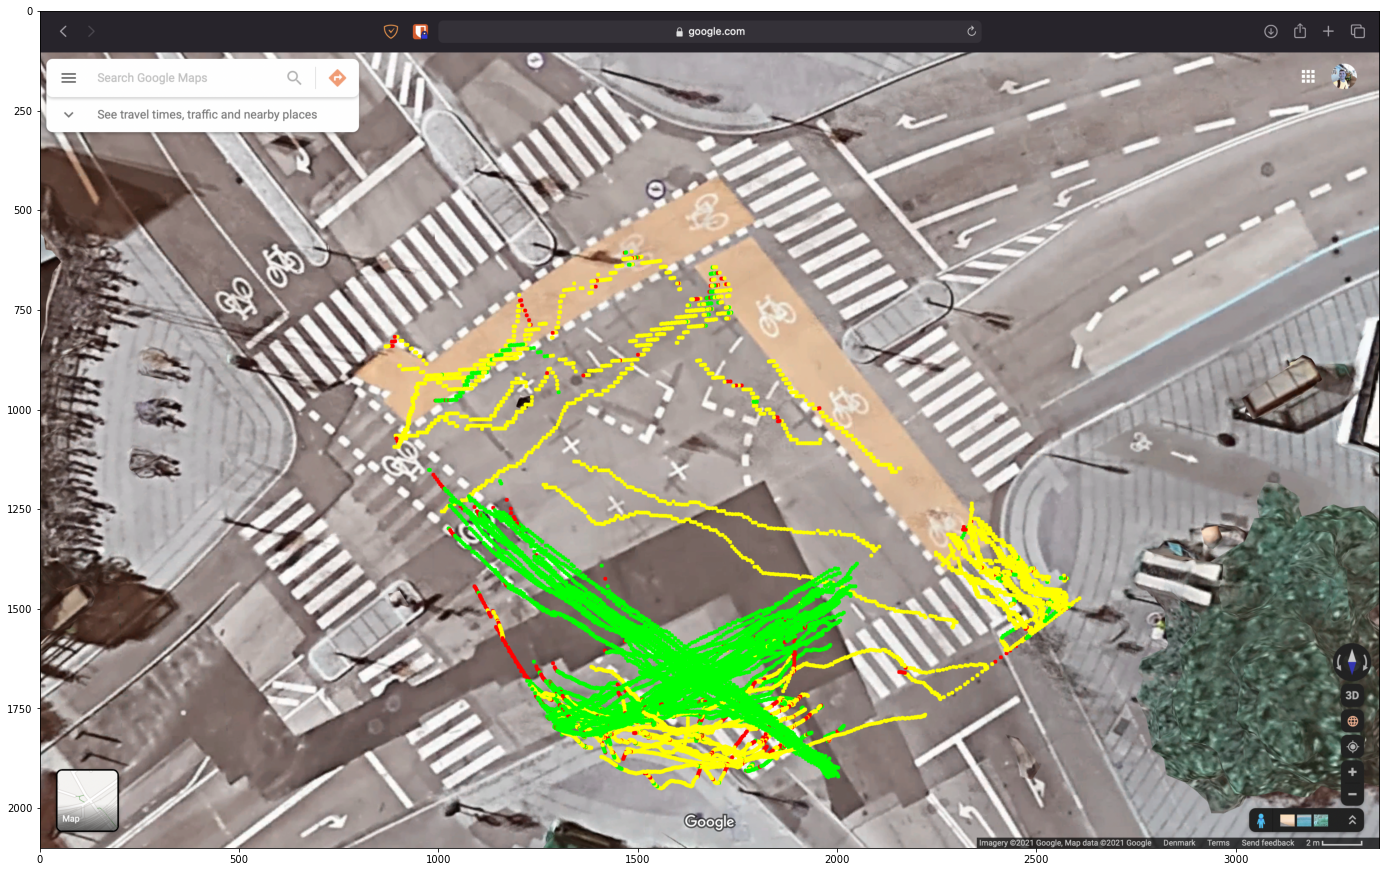

In [144]:
from matplotlib import pyplot as plt
plt.figure(figsize=(24,24))
plt.imshow(im_out)
#plt.savefig('Video_overlay.png')
plt.show()

In [95]:
#unique_id_set = set()
#for index, row in tracker_df.iterrows():
#    unique_id_set.add(row["UniqueID"])

#for i in unique_id_set:
#    #im_out = cv2.warpPerspective(im_src, matrix, (im_dst.shape[1],im_dst.shape[0]))
#    df = tracker_df[tracker_df["UniqueID"] == i]
#    x_list, y_list, colour_list = x_y_colour_list(df)
#    im_out = plot_cyclist_paths(x_list , y_list, colour_list, matrix, im_dst)
#    plt.figure(figsize=(24,24))
#    plt.imshow(im_out)
#    plt.show()
#    input("Press Enter to continue...")
#    clear_output(wait=True)

In [ ]:
#plt.savefig('Google_maps_overlay.png')

In [ ]:
#pd.set_option('display.min_rows', 50)

# EDA

In [ ]:
# Plot accuracy and length of paths.